In [26]:
import torch
import torch.utils.data as data
import torchvision.transforms as tfs

import random

from src.visualize_func import draw_boxes_simple
from src.YoloCigaretteDataset import get_pos_neg_files, YoloCigaretteDataset
from src.visualizeRandomSamples import visualize_random_samples

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# Параметры (можно менять) 
TRAIN_IMG_DIR = "Dataset/train/images"
TRAIN_LABEL_DIR = "Dataset/train/labels"

VAL_IMG_DIR = "Dataset/val/images"
VAL_LABEL_DIR = "Dataset/val/labels"

# сколько хотим взять
TRAIN_POS_N = 2000
TRAIN_NEG_N = 2000

VAL_POS_N = 250
VAL_NEG_N = 250

BATCH_SIZE = 8
KEEP_CLASS = 0  # класс сигареты

# Получаем списки для train и val
train_pos_all, train_neg_all = get_pos_neg_files(TRAIN_IMG_DIR, TRAIN_LABEL_DIR, keep_class=KEEP_CLASS)
val_pos_all, val_neg_all     = get_pos_neg_files(VAL_IMG_DIR, VAL_LABEL_DIR, keep_class=KEEP_CLASS)

print("Всего доступных (train): pos =", len(train_pos_all), "neg =", len(train_neg_all))
print("Всего доступных (val):   pos =", len(val_pos_all),   "neg =", len(val_neg_all))

# Перемешиваем и режем по нужному кол-ву (по факту можно добавить проверку на длину)
random.shuffle(train_pos_all)
random.shuffle(train_neg_all)
random.shuffle(val_pos_all)
random.shuffle(val_neg_all)

train_pos = train_pos_all[:TRAIN_POS_N]
train_neg = train_neg_all[:TRAIN_NEG_N]

val_pos = val_pos_all[:VAL_POS_N]
val_neg = val_neg_all[:VAL_NEG_N]

train_files = train_pos + train_neg
val_files = val_pos + val_neg

random.shuffle(train_files)
random.shuffle(val_files)

print("Финально для train взято:", len(train_files), "(pos,neg) =", len(train_pos), len(train_neg))
print("Финально для val   взято:", len(val_files),   "(pos,neg) =", len(val_pos),   len(val_neg))

transforms_train = tfs.Compose([
    # tfs.RandomResizedCrop(64, scale=(0.8, 1.0)),  
    # tfs.RandomHorizontalFlip(p=0.5),
    # tfs.RandomRotation(10),
    tfs.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    tfs.ToTensor(),
    # tfs.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transforms_val = tfs.Compose([
    tfs.ToTensor(),
    # tfs.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#Создаём датасеты и лоадеры 
train_dataset = YoloCigaretteDataset(TRAIN_IMG_DIR, TRAIN_LABEL_DIR, train_files, transform=transforms_train, keep_class=KEEP_CLASS, RCNN=True)
val_dataset   = YoloCigaretteDataset(VAL_IMG_DIR,   VAL_LABEL_DIR,   val_files,   transform=transforms_val, keep_class=KEEP_CLASS, RCNN=True)

train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=lambda batch: tuple(zip(*batch)))
val_loader   = data.DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda batch: tuple(zip(*batch)))

Всего доступных (train): pos = 5088 neg = 3037
Всего доступных (val):   pos = 257 neg = 338
Финально для train взято: 4000 (pos,neg) = 2000 2000
Финально для val   взято: 500 (pos,neg) = 250 250


In [34]:
train_dataset[3]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 {'boxes': tensor([[1395.5000,  454.0000, 1474.5000,  490.0000]]),
  'labels': tensor([1])})

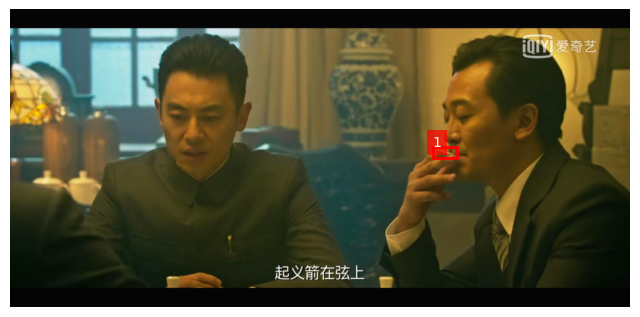

In [35]:
draw_boxes_simple(train_dataset[3][0], train_dataset[3][1]['boxes'], train_dataset[3][1]['labels'])

In [ ]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

num_classes = 2  # фон + сигарета

weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

for p in model.backbone.parameters():
    p.requires_grad = False # морожу все параметры / отключаю обучение
for p in model.backbone.fpn.parameters():
    p.requires_grad = True   # FPN обязательно нужно обучать!

for p in model.backbone.body.layer3.parameters():
    p.requires_grad = True
for p in model.backbone.body.layer4.parameters():
    p.requires_grad = True
    
model.transform.min_size = (480, ) # размеры изобрадения
model.transform.max_size = 800

model.rpn.post_nms_top_n_train = 1000 # Кол-во потенциальных боксов
model.rpn.post_nms_top_n_test = 100

model.rpn.pre_nms_top_n_train = 1000
model.rpn.pre_nms_top_n_test = 500

model.roi_heads.batch_size_per_image = 128 # Это размер батча для обучения ROI - можно сократить и оптимизирвоать модель
model.roi_heads.positive_fraction = 0.25 # Это влияет на долю позитива, который пойдет в ROI

In [37]:
from tqdm.auto import tqdm
from torchmetrics.detection.mean_ap import MeanAveragePrecision
metric = MeanAveragePrecision(iou_thresholds=[0.5]).to(device)

# model = MyFasterRCNN(2)

model = model.to(device)

epochs = 10
optimizer = torch.optim.AdamW(params=[p for p in model.parameters() if p.requires_grad], lr=1e-4, weight_decay=1e-4)

best_map = 0
for epoch in range(epochs):
    
    metric.reset()
    
    train_bar = tqdm(train_loader, desc=f'Эпоха тренировочная {epoch+1}/{epochs}', position=0)
    
    model.train()
    for x_train, y_train in train_bar:
        x_train = [x.to(device) for x in x_train]
        y_train = [{k: v.to(device) for k, v in t.items()} for t in y_train]
        
        loss = sum(model(x_train, y_train).values())

        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_bar.set_postfix({
            'loss': loss
        })

        
    model.eval()
    
    val_bar = tqdm(val_loader, desc=f'Эпоха валидационная {epoch+1}/{epochs}', position=0)
    for x_val, y_val in val_bar:
        
        x_val = [x.to(device) for x in x_val]
        y_val = [{k: v.to(device) for k, v in t.items()} for t in y_val]
        
        with torch.no_grad():
            pred = model(x_val)
            
        metric.update(pred, y_val)
        res = metric.compute()
        _map = float(res['map_50'].item())
        
        val_bar.set_postfix({
            'map': _map
        })

    
    if _map >= best_map:
        print(f'Сохранена модел с результатом MAP: {_map}')
        best_map = _map
        torch.save(model.state_dict(), 'best_model_frcnn.tar')

/home/aleksandr/.pyenv/versions/cigaret_detection/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Эпоха валидационная 1/10: 100%|██████████| 63/63 [02:33<00:00,  2.43s/it, map=0.613]


Сохранена модел с результатом MAP: 0.6132366061210632


Эпоха валидационная 2/10: 100%|██████████| 63/63 [02:17<00:00,  2.19s/it, map=0.685]


Сохранена модел с результатом MAP: 0.6852678060531616


Эпоха валидационная 3/10: 100%|██████████| 63/63 [02:19<00:00,  2.21s/it, map=0.753]


Сохранена модел с результатом MAP: 0.7534715533256531


Эпоха валидационная 10/10: 100%|██████████| 63/63 [01:59<00:00,  1.90s/it, map=0.712]
